In [259]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, List

In [270]:
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target
model = RandomForestRegressor(max_depth=6, max_features="sqrt", max_samples=0.8).fit(X, y)

In [210]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [211]:
base_estimator = model.base_estimator_ 
# sklearn.tree.DecisionTreeRegressor
# nie wiadomo, po co jest, nie działa

In [212]:
forest = model.estimators_ 
# list of `sklearn.tree.DecisionTreeRegressor`s

In [246]:
decision_tree = forest[5]
# sklearn.tree.DecisionTreeRegressor

In [247]:
decision_tree_object = decision_tree.tree_
# sklearn.tree._tree.Tree
# underlying tree object 

In [249]:
# help(sklearn.tree._tree.Tree)
# node_count 
# capacity 
# max_depth 
# children_left -- list of left children IDs (s.t. X[:, feature[i]] <= threshold[i])
# children_right -- analogous
# feature -- to split on
# threshold
# value -- prediction on node
# impurity -- value of splitting criterion
# n_node_samples -- number of training samples in node

In [250]:
def get_depths(tree_object):
    current_lvl_ids = [0]
    next_lvl_ids = np.array([])
    depth = np.zeros(decision_tree_object.node_count)
    current_lvl = 0
    while(len(current_lvl_ids)>0):
        depth[current_lvl_ids] = current_lvl
        next_lvl_ids = np.hstack((next_lvl_ids, 
                                    decision_tree_object.children_left[current_lvl_ids],
                                    decision_tree_object.children_right[current_lvl_ids]))
        current_lvl_ids = list(next_lvl_ids[next_lvl_ids >= 0].astype(int))
        next_lvl_ids = np.array([])
        current_lvl += 1
    return depth.astype(int)

In [251]:
tree_df = pd.DataFrame({
    "id": range(decision_tree_object.node_count),
    "left_child": decision_tree_object.children_left,
    "right_child": decision_tree_object.children_right,
    "depth": get_depths(decision_tree_object),
    "split_variable": decision_tree_object.feature,
    "threshold": decision_tree_object.threshold,
    #"status": (decision_tree_object.children_left >= 0).astype(int), #split node = 1, leaf = 0
    "prediction": decision_tree_object.value.flatten() # dla regresji 
})

In [252]:
tree_df = tree_df.sort_values(by=["depth", "id"]).loc[tree_df["split_variable"] != -2].reset_index(drop=True)
tree_df

,id,left_child,right_child,depth,split_variable,threshold,prediction
0,0,1,64,0,0,5.578800,2.057422
1,1,2,33,1,0,3.198600,1.792455
2,64,65,96,1,0,7.814100,3.636324
3,2,3,18,2,5,2.161098,1.381799
4,33,34,49,2,5,2.326412,2.188594
...,...,...,...,...,...,...,...
58,109,110,111,5,6,33.300001,4.101505
59,114,115,116,5,2,6.507936,3.155000
60,117,118,119,5,4,39.000000,1.906250
61,121,122,123,5,7,-117.064999,4.927902


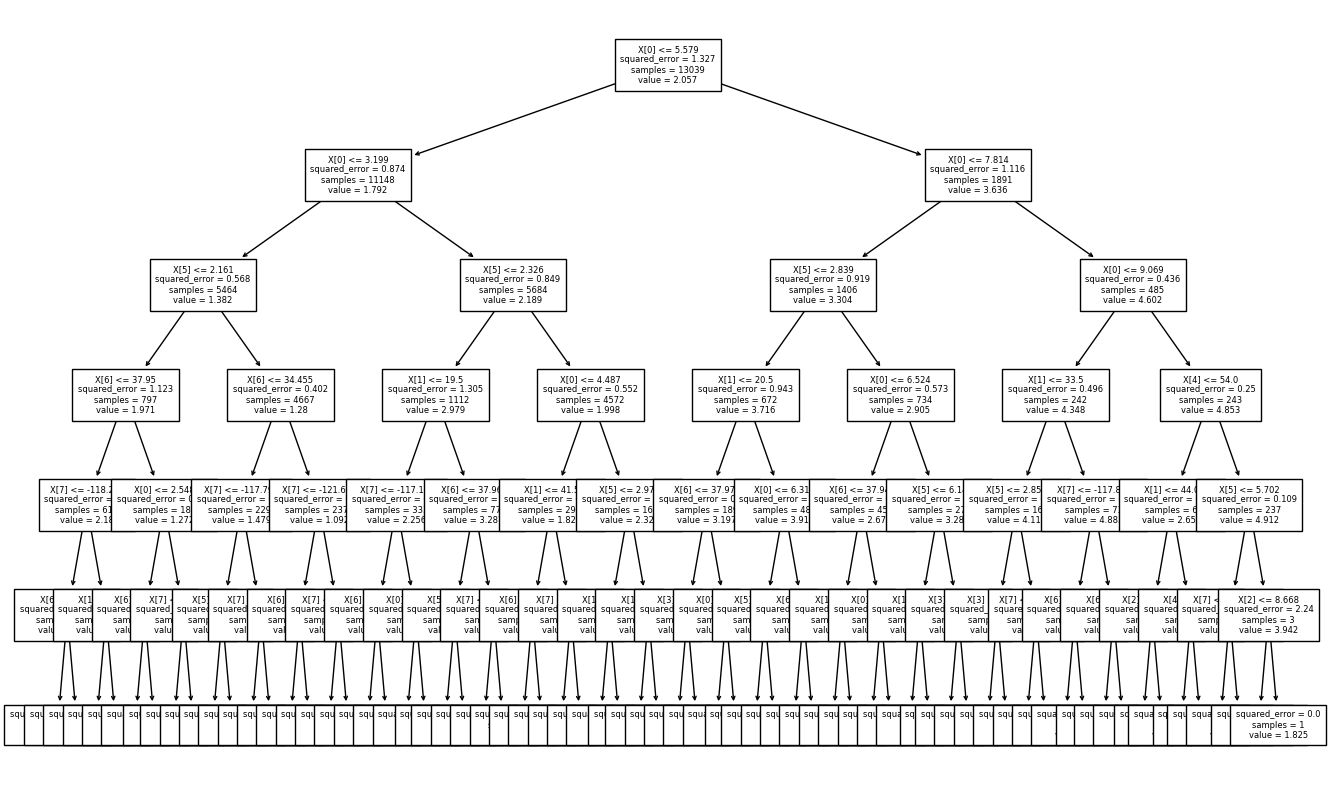

In [253]:
plt.figure(figsize=(16, 10))
sklearn.tree.plot_tree(decision_tree, fontsize=6)
plt.show()

In [107]:
maximal_subtrees_positions = dict(tree_df.groupby("split_variable").depth.idxmin())

In [108]:
maximal_subtrees_positions

{0: 0, 1: 9, 2: 3, 4: 14, 5: 4}

In [109]:
columns_dict = dict(zip(X.columns.to_list(), range(len(X.columns))))

In [110]:
tree_df[list(range(len(X.columns)))] = 0

In [111]:
offset = np.where(tree_df.columns == 0)[0][0]
for i in maximal_subtrees_positions.keys():
    start = maximal_subtrees_positions[i]
    df = tree_df.iloc[start:, ]
    df.iloc[0, i+offset] = 0 
    for k in range(1, len(df)):
        k_id = df.iloc[k, 0]
        subset = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id), ]
        if len(subset) != 0:
            if subset.loc[:, i].values[0] is not None:
                df.iloc[k, i+offset] = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id)][i].values[0] + 1
    tree_df.iloc[start:, i+offset:] = df.iloc[:, i+offset:]
tree_df.iloc[:, offset:] = tree_df.iloc[:, offset:].replace(0, None)

In [268]:
from tqdm import tqdm 

def make_column_dict(X: pd.DataFrame) -> dict:
    return dict(zip(range(len(X.columns)), X.columns.to_list()))

def get_node_depths(tree_object: sklearn.tree._tree.Tree) -> pd.Series:
    current_lvl_ids = [0]
    next_lvl_ids = np.array([])
    depth = np.zeros(tree_object.node_count)
    current_lvl = 0
    while(len(current_lvl_ids)>0):
        depth[current_lvl_ids] = current_lvl
        next_lvl_ids = np.hstack((next_lvl_ids, 
                                    tree_object.children_left[current_lvl_ids],
                                    tree_object.children_right[current_lvl_ids]))
        current_lvl_ids = list(next_lvl_ids[next_lvl_ids >= 0].astype(int))
        next_lvl_ids = np.array([])
        current_lvl += 1
    return depth.astype(int)

def make_tree_df_representation(tree_object: sklearn.tree._tree.Tree) -> pd.DataFrame:
    tree_df =  pd.DataFrame({
        "id": range(tree_object.node_count),
        "left_child": tree_object.children_left,
        "right_child": tree_object.children_right,
        "depth": get_node_depths(tree_object),
        "split_variable": tree_object.feature,
        "threshold": tree_object.threshold,
    })
    tree_df = tree_df.sort_values(by=["depth", "id"]).loc[tree_df["split_variable"] != -2].reset_index(drop=True) #rows with -2 are leaves (no split variable)
    tree_df[list(range(tree_object.n_features))] = 0
    return tree_df
    
def calculate_conditional_minimal_depth_one_tree(decision_tree: Union[sklearn.tree.DecisionTreeClassifier, sklearn.tree.DecisionTreeRegressor], id: int) -> pd.DataFrame:
    tree_object = decision_tree.tree_
    tree_df = make_tree_df_representation(tree_object)
    offset = np.where(tree_df.columns == 0)[0][0]
    maximal_subtrees_positions = dict(tree_df.groupby("split_variable").depth.idxmin())
    for i in maximal_subtrees_positions.keys():
        start = maximal_subtrees_positions[i]
        df = tree_df.iloc[start:, ]
        df.iloc[0, i+offset] = 0 
        for k in range(1, len(df)):
            k_id = df.iloc[k, 0]
            subset = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id), ]
            if len(subset) != 0 and subset.loc[:, i].values[0] is not None:
                df.iloc[k, i+offset] = df.loc[(df["left_child"] == k_id) | (df["right_child"] == k_id)][i].values[0] + 1
        tree_df.iloc[start:, i+offset:] = df.iloc[:, i+offset:]
    tree_df.iloc[:, offset:] = tree_df.iloc[:, offset:].replace(0, None)
    tree_result = tree_df.groupby("split_variable").min().iloc[:,offset-1:] - 1
    tree_result = tree_result.reset_index()
    tree_result.insert(0, "tree_id", id)
    return tree_result

def calculate_conditional_minimal_depths(trees: List[Union[sklearn.tree.DecisionTreeClassifier, sklearn.tree.DecisionTreeRegressor]], show_progress: bool) -> pd.DataFrame:
    tree_result_list = [calculate_conditional_minimal_depth_one_tree(trees[id], id) for id in tqdm(range(len(trees)), disable=not show_progress)]
    forest_result = pd.concat(tree_result_list, ignore_index=True)
    return forest_result

def summarise_results(raw_result_df: pd.DataFrame, column_dict: dict) -> pd.DataFrame:
    final_result = pd.melt(raw_result_df, id_vars=["tree_id", "split_variable"], value_vars=list(range(len(column_dict))))
    final_result = final_result.rename({"split_variable": "variable", "variable": "root_variable"}, axis=1)[~pd.isna(final_result["value"])] \
                                .groupby(["variable", "root_variable"]).agg({"tree_id": "size", "value": "mean"}).reset_index() \
                                .rename({"tree_id": "n_occurences", "value": "mean_min_cond_depth"}, axis=1) \
                                .sort_values(by=["n_occurences", "mean_min_cond_depth"], ascending=[False, True])
    final_result["variable"] = final_result["variable"].map(column_dict)
    final_result["root_variable"] = final_result["root_variable"].map(column_dict)
    return final_result
    
def fit(model: Union[sklearn.ensemble.RandomForestClassifier, sklearn.ensemble.RandomForestRegressor], X: pd.DataFrame, show_progress: bool = True) -> pd.DataFrame:
    column_dict = make_column_dict(X)
    raw_result_df = calculate_conditional_minimal_depths(model.estimators_, show_progress)
    result_df = summarise_results(raw_result_df, column_dict)
    return result_df

In [271]:
res = fit(model, X)
res.head(15)

100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


,variable,root_variable,n_occurences,mean_min_cond_depth
7,MedInc,Longitude,100,0.090000
1,MedInc,HouseAge,100,0.160000
6,MedInc,Latitude,100,0.270000
54,Latitude,Latitude,100,0.270000
0,MedInc,MedInc,100,0.300000
63,Longitude,Longitude,100,0.370000
22,AveRooms,Latitude,100,0.420000
48,Latitude,MedInc,100,0.450000
23,AveRooms,Longitude,100,0.480000
56,Longitude,MedInc,100,0.570000
